In [26]:
#this is a kaggle dataset and we're performing EDA (Exploratory Data Analysis) on the given dataset. 
#In this, we are applying various machine learning algorithms to predict the survival of the passengers in the tragedy.


#importing dependencies
%matplotlib inline

#importing the python libraries:
import math, time, random, datetime

#data manipulation:
import numpy as np
import pandas as pd

#for visualization:
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use("seaborn-whitegrid")

#preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

#import ML algorithms
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier 
from sklearn.tree import DecisionTreeClassifier

In [18]:
#importing train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('gender_submission.csv')

In [19]:
#this is our training set
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [20]:
#number of rows in training set
len(train)

891

In [21]:
#this is our test set
test.head() #head shows top 5 data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [22]:
#number of rows in test set
len(test)

418

In [23]:
train.describe() #this shoes that we have some missing data in age coulmn.

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


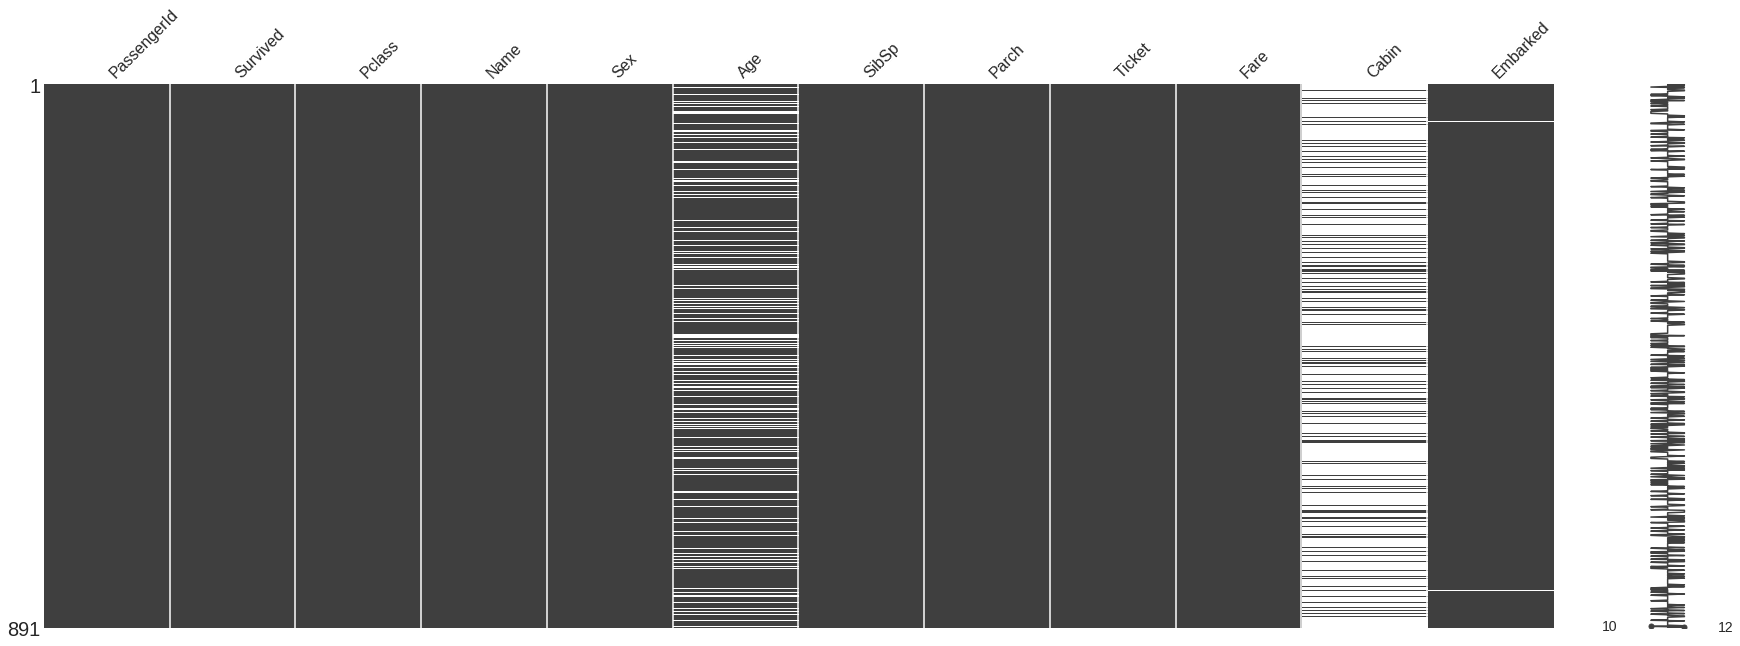

In [27]:
missingno.matrix(train, figsize = (30, 10))

In [29]:
#columns are
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [41]:
#find the number of missing values in each column
#we can call it our missing data dictionary

def find_missing_values(df, columns):
    missing_values = {}
    print("number of missing and NaN values for each columns")
    df_length = len(df)
    for column in columns:
        total_column_values = df[column].value_counts().sum()
        missing_values[column] = df_length-total_column_values
    return missing_values
missing_values = find_missing_values(train, columns = train.columns)

#printing dictionary
missing_values

number of missing and NaN values for each columns


{'PassengerId': 0,
 'Survived': 0,
 'Pclass': 0,
 'Name': 0,
 'Sex': 0,
 'Age': 177,
 'SibSp': 0,
 'Parch': 0,
 'Ticket': 0,
 'Fare': 0,
 'Cabin': 687,
 'Embarked': 2}

In [43]:
#before we start analysing, let's create two dataframes

df_bin = pd.DataFrame() #for discretized continuous variables
df_con = pd.DataFrame() #for continuous variables

In [46]:
#now let's check the datatypes in our data sets
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [68]:
#now we'll see each column one by one

In [ ]:
#SURVIVED

0    549
1    342
Name: Survived, dtype: int64


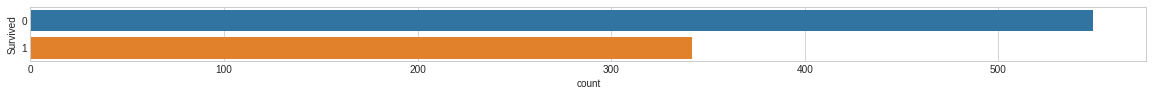

In [57]:
#here we are looking for the number of people survived in the training set

fig = plt.figure(figsize = (20,1))
sns.countplot(y = 'Survived', data = train)
print(train.Survived.value_counts())

In [58]:
#putting the values in both the dataframes

df_bin['Survived'] = train['Survived']
df_con['Survived'] = train['Survived']

In [59]:
df_bin.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [60]:
df_con.head()

,Survived
0,0
1,1
2,1
3,1
4,0


In [ ]:
#PCLASS

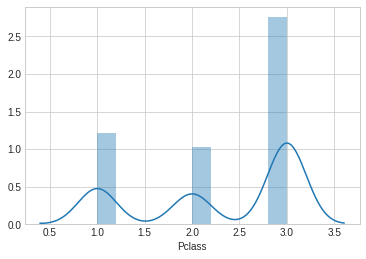

In [64]:
sns.distplot(train.Pclass)

In [73]:
missing_values['Pclass'] #missing value in pclass

0

In [74]:
#let's put it in our dataframes

df_bin['Pclass'] = train['Pclass']
df_con['Pclass'] = train['Pclass']

In [75]:
df_bin.head()

,Survived,Pclass
0,0,3
1,1,1
2,1,3
3,1,1
4,0,3


In [76]:
df_con.head()

,Survived,Pclass
0,0,3
1,1,1
2,1,3
3,1,1
4,0,3


In [77]:
#NAMES

In [79]:
#different names in training set

train.Name.value_counts()

Skoog, Mrs. William (Anna Bernhardina Karlsson)         1
Chronopoulos, Mr. Apostolos                             1
Frauenthal, Dr. Henry William                           1
Romaine, Mr. Charles Hallace ("Mr C Rolmane")           1
Padro y Manent, Mr. Julian                              1
Crosby, Miss. Harriet R                                 1
Clifford, Mr. George Quincy                             1
Allison, Mrs. Hudson J C (Bessie Waldo Daniels)         1
Van der hoef, Mr. Wyckoff                               1
Carter, Rev. Ernest Courtenay                           1
Davies, Mr. Charles Henry                               1
Carrau, Mr. Francisco M                                 1
Johansson, Mr. Gustaf Joel                              1
Mineff, Mr. Ivan                                        1
Christy, Miss. Julie Rachel                             1
Laroche, Miss. Simonne Marie Anne Andree                1
Sutton, Mr. Frederick                                   1
Dick, Mrs. Alb

In [81]:
#SEX

male      577
female    314
Name: Sex, dtype: int64


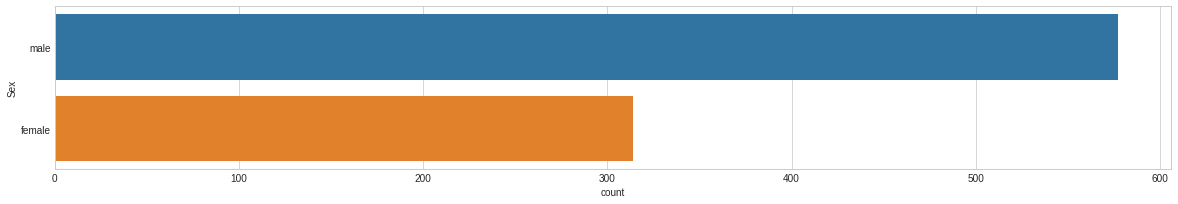

In [85]:
#here we calculate the number of males and females in our training set

plt.figure(figsize = (20,3))
sns.countplot(y = 'Sex', data = train)
print(train.Sex.value_counts())

In [89]:
#since this is a binary variable, so let's add it to our subset dataframes

df_bin['Sex'] = train['Sex']
#the following line will assign '1' if the sex is female, otherwise 0;
df_bin['Sex'] = np.where(df_bin['Sex'] == 'female', 1, 0)
df_con['Sex'] = train['Sex']

In [ ]:
#now let's compare the survival column with sex column